In [2]:
import pandas as pd

# Loading CO₂ dataset
co2 = pd.read_csv("co2_trend_gl.csv", comment='#')

# Checking the column names
print(co2.columns)


Index(['year', 'month', 'day', 'smoothed', 'trend'], dtype='object')


In [4]:
# Combining date columns
co2['Date'] = pd.to_datetime(dict(year=co2['year'], month=co2['month'], day=co2['day']))

#Cleaning data
co2 = co2[['Date', 'trend']].rename(columns={'trend': 'CO2'})

# Filtering
co2 = co2[co2['Date'].dt.day == 1].reset_index(drop=True)

co2.head()

,Date,CO2
0,2015-01-01,398.51
1,2015-02-01,398.70
2,2015-03-01,398.88
3,2015-04-01,399.09
4,2015-05-01,399.29


In [8]:
# Loading NASA GISS temperature anomaly file
temp = pd.read_csv("GLB.Ts+dSST.csv", skiprows=1)

# Removing footer or metadata rows (anything where 'Year' is not a valid integer)
temp = temp[temp['Year'].apply(lambda x: str(x).isdigit())]

# Converting year column to int
temp['Year'] = temp['Year'].astype(int)

# Selecting only the first 13 columns: Year + Jan–Dec
temp = temp.iloc[:, :13]

# Droping rows with any missing monthly data
temp = temp.dropna()

# Melting the dataframe to long format
temp_long = temp.melt(id_vars=['Year'], var_name='Month', value_name='Anomaly')

# Mapping month names to numbers
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
             'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
temp_long['Month'] = temp_long['Month'].map(month_map)

# Creating datetime column
temp_long['Date'] = pd.to_datetime(dict(year=temp_long['Year'], month=temp_long['Month'], day=1))

# Final cleanup
temp_long = temp_long[['Date', 'Anomaly']].dropna()


temp_long.head()


,Date,Anomaly
0,2002-01-01,*******
1,2003-01-01,0.035
2,2004-01-01,0.059
3,2005-01-01,0.041
4,2006-01-01,-0.018


In [10]:
# Merging Date
climate_df = pd.merge(co2, temp_long, on='Date', how='inner')


climate_df.head()


,Date,CO2,Anomaly
0,2015-01-01,398.51,0.097
1,2015-01-01,398.51,0.108
2,2015-01-01,398.51,0.146
3,2015-02-01,398.70,0.176
4,2015-02-01,398.70,0.222


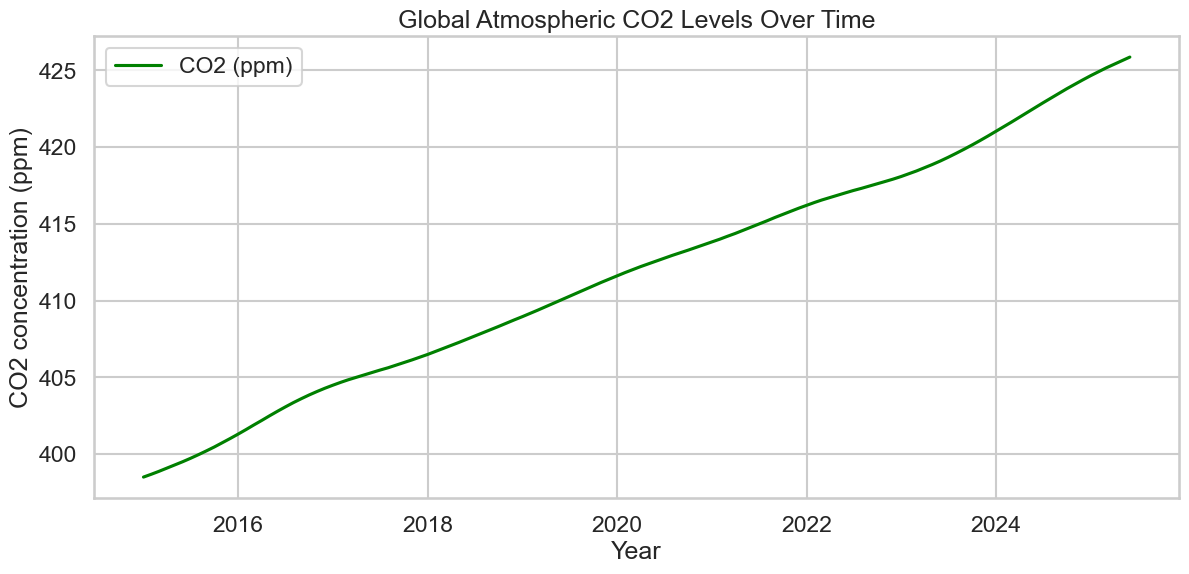

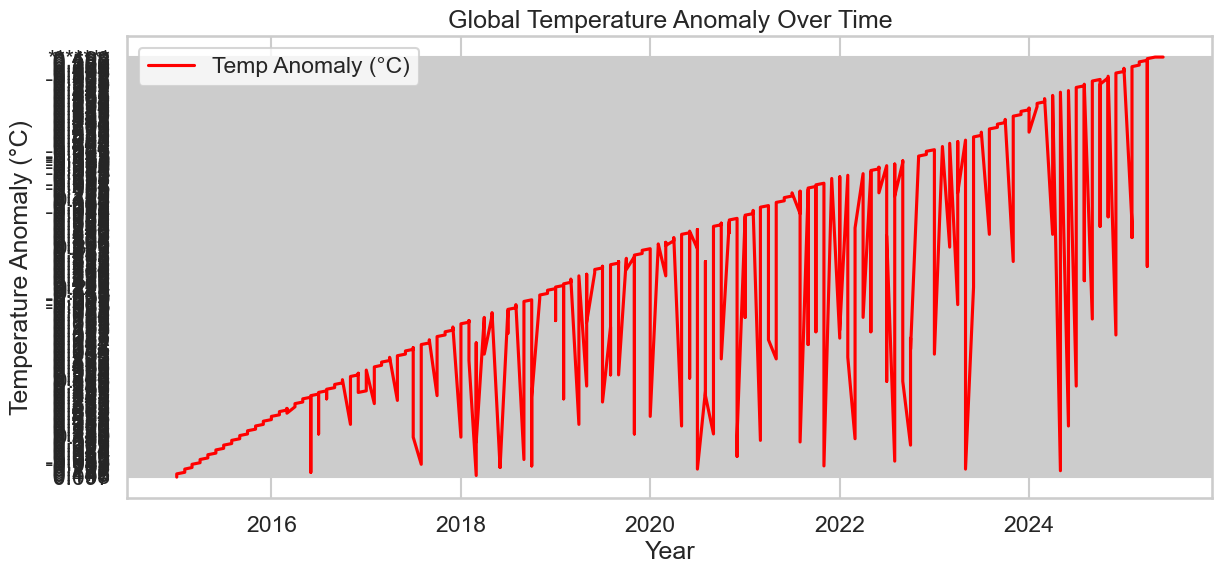

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 6))
plt.plot(climate_df['Date'], climate_df['CO2'], label='CO2 (ppm)', color='green')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Year')
plt.title('Global Atmospheric CO2 Levels Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(climate_df['Date'], climate_df['Anomaly'], label='Temp Anomaly (°C)', color='red')
plt.ylabel('Temperature Anomaly (°C)')
plt.xlabel('Year')
plt.title('Global Temperature Anomaly Over Time')
plt.legend()
plt.show()



In [28]:
for col in ['CO2', 'Anomaly']:
    climate_df[col] = pd.to_numeric(climate_df[col], errors='coerce')


In [32]:
climate_df['CO2'] = pd.to_numeric(climate_df['CO2'], errors='coerce')
climate_df['Anomaly'] = pd.to_numeric(climate_df['Anomaly'], errors='coerce')

climate_df_clean = climate_df.dropna(subset=['CO2', 'Anomaly'])

from sklearn.linear_model import LinearRegression


X = climate_df_clean[['CO2']]
y = climate_df_clean['Anomaly']

# Filinear regression
model = LinearRegression().fit(X, y)

# Output results
print(f"R² = {model.score(X, y):.3f}")
print(f"Intercept = {model.intercept_:.3f}, Slope = {model.coef_[0]:.3f}")


R² = 0.073
Intercept = -2.281, Slope = 0.006


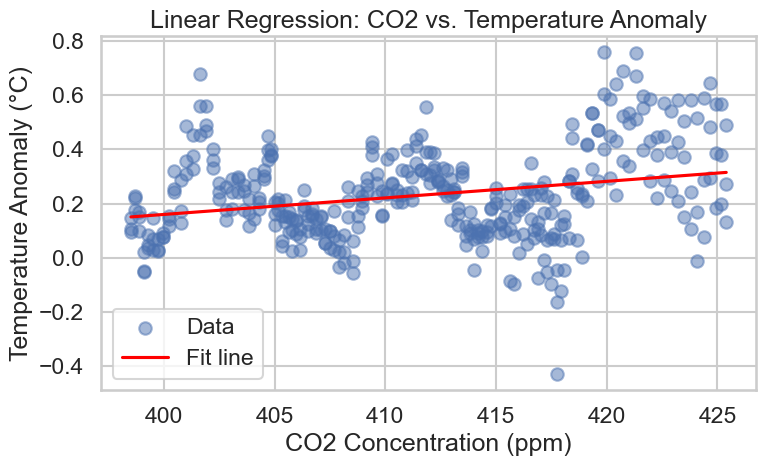

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.5, label="Data")
plt.plot(X, model.predict(X), color='red', label="Fit line")
plt.xlabel("CO2 Concentration (ppm)")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Linear Regression: CO2 vs. Temperature Anomaly")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


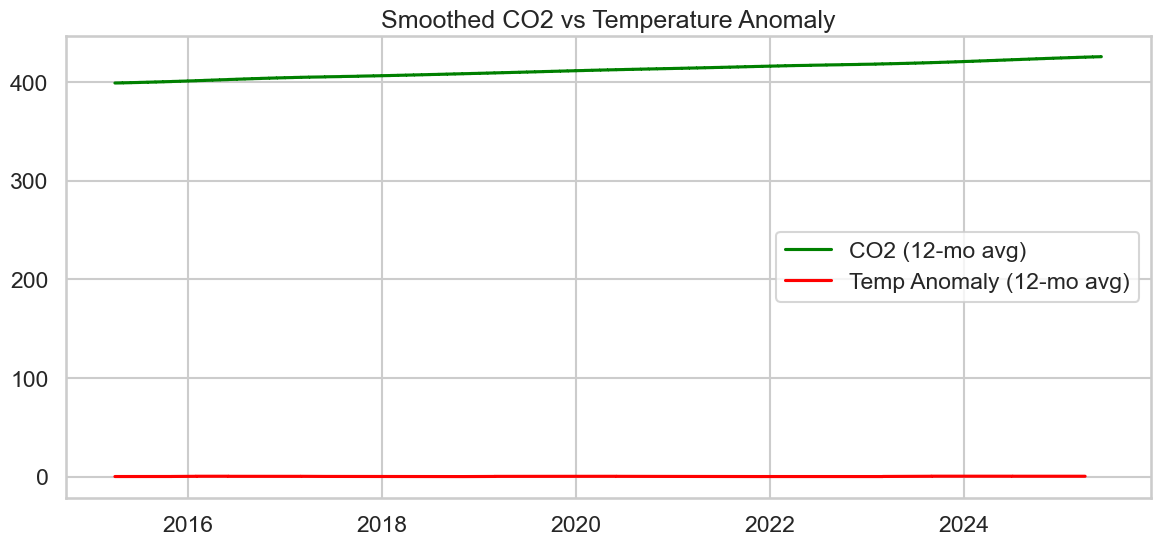

In [40]:
climate_df['CO2_smooth'] = climate_df['CO2'].rolling(12).mean()
climate_df['Anomaly_smooth'] = climate_df['Anomaly'].rolling(12).mean()

plt.figure(figsize=(14, 6))
plt.plot(climate_df['Date'], climate_df['CO2_smooth'], label='CO2 (12-mo avg)', color='green')
plt.plot(climate_df['Date'], climate_df['Anomaly_smooth'], label='Temp Anomaly (12-mo avg)', color='red')
plt.title('Smoothed CO2 vs Temperature Anomaly')
plt.legend()
plt.show()
